In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

from IS2ML_utils import *

In [2]:
fn_features = 'data_paper/lake_segments_depth_features.parquet'
fn_info = 'data_paper/lake_segments_info.parquet'

df_feat = pd.read_parquet(fn_features).reset_index(drop=True)
df_info = pd.read_parquet(fn_info)

idxs = [3, 4, 5, 8, 11, 12, 14, 16, 46, 71, 74, 80]
idxs = []
valid_ids = df_info.index[idxs]
is_valid = df_feat.apply(lambda x: x.IS2_id in valid_ids, axis=1)
df_feat_valid = df_feat[is_valid].copy()
df_feat_traintest = df_feat[~is_valid].copy()
depth_valid = df_feat_valid.depth
pred_valid = df_feat_valid.iloc[:, 6:]
df_info_traintest = df_info[~df_info.index.isin(valid_ids)].copy()
df_info_valid = df_info.loc[valid_ids].copy()

# Random Forest Recursive Feature Elimination

In [3]:
cv_fold_n = 10

frac_train = 1.0
n_estimators = 1000 # int, default=100
max_features = 0.4 # {“sqrt”, “log2”, None}, int or float, default=1.0 (i.e. max_features=n_features)
max_samples = 0.05 # default=None
min_samples_leaf = 1 # default=1

print('%i - fold cross validation' % cv_fold_n)
print('frac_train = %g\nn_estimators = %g\nmax_features = %g\nmax_samples = %g\n' % (frac_train, n_estimators, max_features, max_samples))

feature_list = np.array(list(df_feat)[6:]) # this will change in each iteration, as features are dropped
iter = 0

iterdfs = [] # to store performance stats and number of features for each elimination round
feat_lists = [] # store feature lists for each round

while len(feature_list) > 0: 

    iter += 1
    nfeat = len(feature_list)
    print('iter = %2d, n_feat = %2d | ' % (iter, nfeat), end='')
    
    df_info_traintest['cv_assign'] = np.random.permutation(np.arange(len(df_info_traintest)) % cv_fold_n)
    cv_depth_dfs = [] # to store the labels and predicted depths for each fold
    imp_list = [] # feature importances by fold
    
    for icv in range(cv_fold_n):
    
        print('%i' % icv, end='')
    
        df_info_test = df_info_traintest[df_info_traintest.cv_assign == icv]
        df_info_train = df_info_traintest[df_info_traintest.cv_assign != icv]
        test_ids = df_info_test.index
        is_test = df_feat.apply(lambda x: x.IS2_id in test_ids, axis=1)
        df_feat_test = df_feat[is_test]
        df_feat_train_full = df_feat[~is_test]
        depth_test = df_feat_test.depth
        pred_test = df_feat_test[feature_list]
        
        df_feat_train = df_feat_train_full.sample(frac=frac_train, replace=False)
        depth_train = df_feat_train.depth
        pred_train = df_feat_train[feature_list]
    
        # Random Forest Regression
        # print('training...', end=' ')
        # start_time = time.time()
        rf = RandomForestRegressor(n_estimators=n_estimators, criterion='squared_error',# random_state=42, 
                                   max_features=max_features, max_samples=max_samples, min_samples_leaf=min_samples_leaf, n_jobs=-1)
        rf.fit(pred_train, depth_train)
        # print('finished in %s' % duration_string(time.time() - start_time))
        
        # print('fitting...', end=' ')
        # start_time = time.time()
        depth_pred = rf.predict(pred_test)
        # print('finished in %s' % duration_string(time.time() - start_time))
    
        # # Predictions and evaluation
        # is2nz = df_feat_test.depth > 0
        # prednz = pred_test.ndwi > 0.14
        # depth_test_nnz = depth_test[is2nz & prednz]
        # depth_pred_nnz = depth_pred[is2nz & prednz]
    
        # mae = mean_absolute_error(depth_test_nnz, depth_pred_nnz)
        # mse = mean_squared_error(depth_test_nnz, depth_pred_nnz)
        # bias = np.nanmean(depth_test_nnz - depth_pred_nnz)
        # df_cvstats_nnz.loc[icv] = [mae, mse, bias]
        # print(f'Mean Absolute Error (NNZ): {mae}')
        # print(f'Mean Squared Error (NNZ): {mse}')
        # print(f'Mean Bias (NNZ): {bias}')
    
        dfdepths = pd.DataFrame({'is2': depth_test, 'rf_pred': depth_pred, 'cv_fold': icv+1, 'ndwi': df_feat_test.ndwi})
        
        cv_depth_dfs.append(dfdepths)
        imp_list.append(rf.feature_importances_)
    
    # cv_stats_mean = df_cvstats_nnz.mean()
    # cv_stats_error = df_cvstats_nnz.std()
    
    cv_depths = pd.concat(cv_depth_dfs)
    is2nnz = cv_depths.is2 > 0
    ndwinnz = cv_depths.ndwi > 0.14
    cv_valid = cv_depths[is2nnz & ndwinnz]
    corrcv = pearsonr(cv_valid.is2, cv_valid.rf_pred).statistic
    maecv = np.mean(np.abs(cv_valid.is2 - cv_valid.rf_pred))
    rmsecv = np.sqrt(np.mean((cv_valid.is2 - cv_valid.rf_pred)**2))
    biascv = np.mean(cv_valid.is2 - cv_valid.rf_pred)

    dfperf = pd.DataFrame({
        'iter': iter,
        'n_feat': nfeat,
        'mae': maecv,
        'rmse': rmsecv,
        'corr': corrcv,
        'bias': biascv
    }, index=[iter])
    
    imp_median = np.median(np.array(imp_list), axis=0)
    errs = np.std(np.array(imp_list), axis=0)
    perc75 = np.percentile(np.array(imp_list), 75, axis=0)
    perc25 = np.percentile(np.array(imp_list), 25, axis=0)
    imp_df = pd.DataFrame({'feat_name': feature_list, 
                           'importance': imp_median, 
                           'stdev': errs, 
                           'perc25': perc25, 
                           'perc75': perc75}).sort_values(by='importance', ascending=False)

    # remove least important variable from list
    to_remove = imp_df.iloc[-1].feat_name
    feature_list = feature_list[feature_list!=to_remove]

    # append data to lists
    feat_lists.append(feature_list.copy())
    iterdfs.append(dfperf)

    print(' | MAE = %6.3f, RMSE = %6.3f, R = %6.3f, bias = %6.3f --> remove: %s' % (maecv, rmsecv, corrcv, biascv, to_remove))

    # make figure for this iteration
    matplotlib.rcParams.update({'font.size': 12})
    fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
    idxsort = np.argsort(-imp_median)
    ax.bar(np.arange(len(imp_df))+1, imp_df.importance, alpha=0.35)
    ax.boxplot(np.array(imp_list)[:,idxsort]);
    ax.plot([0.5,len(imp_df)+0.5], [0]*2, 'r-', lw=0.7)
    ax.set_xticks(np.arange(len(imp_df))+1)
    ax.set_xticklabels(imp_df.feat_name, rotation='vertical', fontsize=12)
    ax.set_xlim((0,len(imp_df)+1))
    ax.set_ylabel('impurity-based feature importance', fontsize=14)
    txt = 'iter = %2d\nn_feat = %2d\nMAE = %5.3f\nRMSE = %5.3f\nR = %5.3f\nbias = %6.3f' % (iter, nfeat, maecv, rmsecv, corrcv, biascv)
    ax.text(0.98, 0.98, txt, transform=ax.transAxes, ha='right', va='top')
    fig.tight_layout()
    figname = 'figs_varimp/rfrfe_%02d.jpg' % iter
    fig.savefig(figname)
    plt.close(fig)
    # display(Image(figname))

10 - fold cross validation
frac_train = 1
n_estimators = 1000
max_features = 0.4
max_samples = 0.05

iter =  1, n_feat = 62 | 0123456789 | MAE =  0.519, RMSE =  0.969, R =  0.955, bias =  0.043 --> remove: MSK_CLDPRB
iter =  2, n_feat = 61 | 0123456789 | MAE =  0.524, RMSE =  0.974, R =  0.954, bias =  0.043 --> remove: SCL
iter =  3, n_feat = 60 | 0123456789 | MAE =  0.518, RMSE =  0.959, R =  0.956, bias =  0.038 --> remove: VZA_B11_cos
iter =  4, n_feat = 59 | 0123456789 | MAE =  0.526, RMSE =  0.987, R =  0.953, bias =  0.045 --> remove: RAA_B6_cos
iter =  5, n_feat = 58 | 0123456789 | MAE =  0.517, RMSE =  0.954, R =  0.956, bias =  0.036 --> remove: VZA_B12_cos
iter =  6, n_feat = 57 | 0123456789 | MAE =  0.521, RMSE =  0.963, R =  0.955, bias =  0.042 --> remove: RAA_B7_cos
iter =  7, n_feat = 56 | 0123456789 | MAE =  0.521, RMSE =  0.968, R =  0.955, bias =  0.040 --> remove: VZA_B3_cos
iter =  8, n_feat = 55 | 0123456789 | MAE =  0.516, RMSE =  0.939, R =  0.958, bias =  0.041

,iter,n_feat,mae,rmse,corr,bias
1,1,62,0.518661,0.969368,0.954591,0.042758
2,2,61,0.524011,0.973617,0.954295,0.043380
3,3,60,0.517889,0.958626,0.955519,0.038448
4,4,59,0.526248,0.987026,0.952965,0.045443
5,5,58,0.516830,0.953969,0.955856,0.035820
...,...,...,...,...,...,...
58,58,5,0.613765,1.058551,0.945026,0.043353
59,59,4,0.629386,1.079398,0.943315,0.047521
60,60,3,0.624202,1.073531,0.943792,0.053314
61,61,2,1.284194,2.088882,0.763363,0.039246


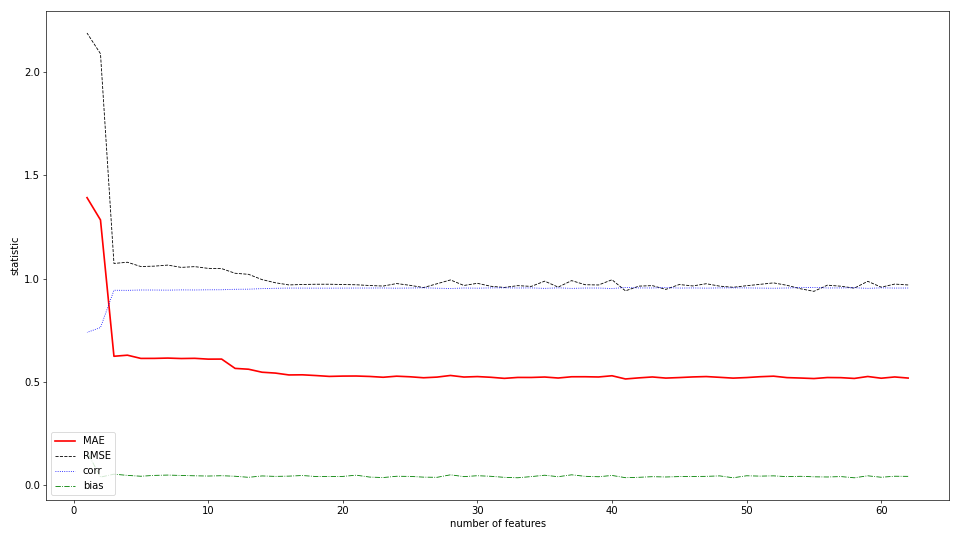

In [5]:
df_stats = pd.concat(iterdfs)

matplotlib.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
ax.plot(df_stats.n_feat, df_stats.mae, 'r-', lw=2, label='MAE')
ax.plot(df_stats.n_feat, df_stats.rmse, 'k--', lw=1, label='RMSE')
ax.plot(df_stats.n_feat, df_stats['corr'], 'b:', lw=1, label='corr')
ax.plot(df_stats.n_feat, df_stats.bias, 'g-.', lw=1, label='bias')
ax.set_xlabel('number of features')
ax.set_ylabel('statistic')
ax.legend(loc='lower left')
fig.tight_layout()

display(df_stats)

In [25]:
fulllist = np.array(list(df_feat)[6:])
ordered_list = list(set(fulllist) - set(feat_lists[0]))
for i in range(len(feat_lists)-1):
    ordered_list.append(list(set(feat_lists[i]) - set(feat_lists[i+1]))[0])
df_stats['eliminated'] = ordered_list
#df_stats.to_csv('rf_recursive_feature_elimination_stats.csv', index=False)
df_stats

,iter,n_feat,mae,rmse,corr,bias,eliminated
1,1,62,0.518661,0.969368,0.954591,0.042758,MSK_CLDPRB
2,2,61,0.524011,0.973617,0.954295,0.043380,SCL
3,3,60,0.517889,0.958626,0.955519,0.038448,VZA_B11_cos
4,4,59,0.526248,0.987026,0.952965,0.045443,RAA_B6_cos
5,5,58,0.516830,0.953969,0.955856,0.035820,VZA_B12_cos
...,...,...,...,...,...,...,...
58,58,5,0.613765,1.058551,0.945026,0.043353,ratio_logB4_logB2
59,59,4,0.629386,1.079398,0.943315,0.047521,diff_logB2_logB3
60,60,3,0.624202,1.073531,0.943792,0.053314,diff_logB3_logB4
61,61,2,1.284194,2.088882,0.763363,0.039246,ratio_logB3_logB2


In [55]:
feat_names = np.array(list(df_feat)[6:])
feat_allvars = np.array(list(df_feat)[6:])
for i,ft in enumerate(feat_names):
    if ft[-4:] == '_log':
        feat_names[i] = 'ln(' + ft[:-4] + ')'
    if ft[-4:] == '_cos':
        feat_names[i] = 'cos(' + ft[:-4] + ')'
    if ft.startswith('ratio_'):
        feat_names[i] = 'ln(%s/%s)' % (ft[9:11], ft[15:])
    if ft.startswith('diff_'):
        feat_names[i] = 'ln(%s)-ln(%s)' % (ft[8:10], ft[14:])
    if ft == 'ndwi':
        feat_names[i] = 'NDWI'
feat_rename = {feat_allvars[i]: feat_names[i] for i in range(len(feat_allvars))}

matplotlib.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
ax.plot(df_stats.n_feat, df_stats.mae, 'r-', lw=2, label='MAE')
ax.fill_between(list(df_stats.n_feat) + [0], 0, list(df_stats.mae) + [10], color='r', alpha=0.1, zorder=-1)
ax.set_xlabel('number of features')
ax.set_ylabel('MAE (m)')
ax.set_title('Random Forest Recursive Feature Eliminiation')
ymin = 0.51
ymax = 0.675
for i in range(len(df_stats)):
    it = df_stats.iloc[i]
    if i > (len(df_stats) - 17):
        ax.text(it.n_feat-0.5, ymin, ' ' + feat_rename[it.eliminated], ha='center', va='bottom', rotation='vertical')
    else:
        ax.text(it.n_feat-0.5, ymax, feat_rename[it.eliminated] + ' ', ha='center', va='top', rotation='vertical')
    if i % 2 != 0:
        ax.fill_between(x=[i, i+1], y1=ymin, y2=ymax, color='C0', alpha=0.1, zorder=-1)
# ax.legend(loc='lower left')
ax.set_ylim((ymin, ymax))
ax.set_xlim((0,62))
fig.tight_layout()
figname = 'figs_varimp/all_rfrfe.jpg'
fig.savefig(figname)
figname = 'plots/random_forest_recursive_feature_elimination.jpg'
fig.savefig(figname, dpi=600)
plt.close(fig)
display(Image(figname))

In [54]:
list(np.flip(np.array(df_stats[df_stats.n_feat < 20].eliminated)))

['B3_log',
 'ratio_logB3_logB2',
 'diff_logB3_logB4',
 'diff_logB2_logB3',
 'ratio_logB4_logB2',
 'B2_log',
 'ratio_logB4_logB3',
 'B4_log',
 'ndwi',
 'B1_log',
 'diff_logB2_logB4',
 'B8_log',
 'B5_log',
 'PhA_B12',
 'B6_log',
 'AOT_log',
 'B7_log',
 'VZA_B4_cos',
 'SZA_cos']

In [18]:
fulllist = np.array(list(df_feat)[6:])
list(set(fulllist) - set(feat_lists[0]))[0]

'MSK_CLDPRB'

In [ ]:
cv_depths = pd.concat(cv_depth_dfs)
is2nnz = cv_depths.is2 > 0
ndwinnz = cv_depths.ndwi > 0.14
cv_valid = cv_depths[is2nnz & ndwinnz]
corrcv = pearsonr(cv_valid.is2, cv_valid.rf_pred).statistic
maecv = np.mean(np.abs(cv_valid.is2 - cv_valid.rf_pred))
rmsecv = np.sqrt(np.mean((cv_valid.is2 - cv_valid.rf_pred)**2))
txt_cv = 'correlation = %.2f\nMAE = %.2f\nRMSE = %.2f' % (corrcv, maecv, rmsecv)
txt_cv

In [ ]:
fig, ax = plt.subplots()
cv_stats_mean = df_cvstats_nnz.mean()
cv_stats_error = df_cvstats_nnz.std()/np.sqrt(cv_fold_n)
bars = ax.bar(cv_stats_mean.index, cv_stats_mean, yerr=cv_stats_error, color='gray')
for ib, bar in enumerate(bars):
    fac = 1.2
    fix = 0.02
    highbar = cv_stats_mean.iloc[ib] > (cv_stats_mean.max()*1.05/5)
    adjust =  - 1.2 * cv_stats_error.iloc[ib] - fix if highbar else 1.2 * cv_stats_error.iloc[ib] + fix
    ypos = cv_stats_mean.iloc[ib] + adjust
    algn = 'top' if highbar else 'bottom'
    xpos = bar.get_x() + bar.get_width() / 2
    label = '%.2f m\n+/- %.2f m' % (cv_stats_mean.iloc[ib], cv_stats_error.iloc[ib])
    ax.text(xpos, ypos, label, ha='center', va=algn, fontsize=10)

# ax.errorbar(cv_stats_mean.index, cv_stats_mean, yerr=cv_stats_error)
ax.set_title('%d-fold cross validation statistics' % cv_fold_n)
ax.set_ylabel('errors (m)')

figname = 'plots/cross_validation_statistics_RF.jpg'
fig.savefig(figname, dpi=300)
plt.close(fig)
display(Image(figname))

# Band ratio

In [ ]:
fn_traindata = 'data_paper/lake_segments_depth_reflectance_data.parquet'
fn_info = 'data_paper/lake_segments_info.parquet'

df_data = pd.read_parquet(fn_traindata).reset_index(drop=True)
df_info = pd.read_parquet(fn_info)

df_data['br23'] = np.log(df_data.B2 / df_data.B3)
df_data['br24'] = np.log(df_data.B2 / df_data.B4)
df_data['br34'] = np.log(df_data.B3 / df_data.B4)
df_data.loc[df_data.B3==1.0,'br23'] = np.nan
df_data.loc[df_data.B4==1.0,'br24'] = np.nan
df_data.loc[df_data.B4==1.0,'br34'] = np.nan
for br in ['br23', 'br24', 'br34']:
    df_data.loc[df_data[br] == np.inf, br] = np.nan

thisband = 'B3'
br = 'br23'
ndwi_thresh = 0.23
dfnz = df_data[(df_data[thisband] > 1.0) & (df_data.ndwi > ndwi_thresh) & (df_data.depth>0)]

# ax.scatter(dfnz[br], dfnz.depth, s=1, color='k', alpha=0.1)
# ax.set_xlabel('ln(B2/B3)')
# ax.set_ylabel('depth (m)')
# ax.set_title('depth vs. band ratio, all training data')

xfit = np.linspace(-0.5, 7)
params = np.polyfit(dfnz[br], dfnz.depth, 2)
# print(params)
pp = np.poly1d(params)
yfit = pp(xfit)
# ax.plot(xfit, yfit, 'r-')
# ax.set_xlim((0,4))
# ax.set_ylim((0,25))
# fig.tight_layout()

is2nz = df_data.depth>0
ndwi_nz = df_data.ndwi > ndwi_thresh
br_valid = df_data[thisband] > 1.0
df_data['br23_pred'] = pp(df_data.br23)
df_data.loc[df_data.ndwi < ndwi_thresh, 'br23_pred'] = 0.0 # following moussavi et al., 2016
is2depth = df_data[is2nz & br_valid].depth
br23depth = df_data[is2nz & br_valid].br23_pred
corr_br23 = pearsonr(br23depth, is2depth).statistic
mae_br23 = np.mean(np.abs(br23depth - is2depth))
rmse_br23 = np.sqrt(np.mean((br23depth - is2depth)**2))
txt_br23 = 'correlation = %.2f\nMAE = %.2f\nRMSE = %.2f' % (corr_br23, mae_br23, rmse_br23)
print(txt_br23)

In [ ]:
plt.close('all')
matplotlib.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(figsize=[16, 8], dpi=60, ncols=2)
cv_depths = pd.concat(cv_depth_dfs)
is2nnz = cv_depths.is2 > 0

ax = axs[0]
ax.scatter(cv_depths.is2[is2nnz], cv_depths.rf_pred[is2nnz], s=1, color='k', alpha=0.1)
ax.plot([0,25], [0,25], 'r-')
ax.set_aspect(1)
ax.set_xlabel('ICESat-2 depth (m)')
ax.set_ylabel('predicted depth, all CV folds (m)')
ax.set_title('Random Forest')
ax.set_xlim((0,25))
ax.set_ylim((0,25))

corrcv = pearsonr(cv_depths.is2, cv_depths.rf_pred).statistic
maecv = np.mean(np.abs(cv_depths.is2[is2nnz] - cv_depths.rf_pred[is2nnz]))
rmsecv = np.sqrt(np.mean((cv_depths.is2 - cv_depths.rf_pred)**2))
txt_cv = 'correlation = %.2f\nMAE = %.2f\nRMSE = %.2f' % (corrcv, maecv, rmsecv)
ax.text(0.02, 0.98, txt_cv, transform=ax.transAxes, ha='left', va='top')
# print(txt_cv)

ax = axs[1]
ax.scatter(is2depth, br23depth, s=1, color='k', alpha=0.1)
ax.plot([0,25], [0,25], 'r-')
ax.set_aspect(1)
ax.set_xlabel('ICESat-2 depth (m)')
ax.set_ylabel('predicted depth (m)')
ax.set_title('Band-Ratio (B2/B3)')
ax.set_xlim((0,25))
ax.set_ylim((0,25))
ax.text(0.02, 0.98, txt_br23, transform=ax.transAxes, ha='left', va='top')

fig.tight_layout()

In [ ]:
np.mean((cv_depths.is2 - cv_depths.rf_pred)**2)

In [ ]:
mean_squared_error(cv_depths.is2, cv_depths.rf_pred)

In [ ]:
pearsonr(cv_depths.is2, cv_depths.rf_pred).statistic

In [ ]:
idxs = [3, 4, 5, 8, 11, 12, 14, 16, 46, 71, 74, 80]
valid_ids = df_info.index[idxs]
is_valid = df_feat.apply(lambda x: x.IS2_id in valid_ids, axis=1)
df_feat_valid = df_feat[is_valid].copy()
df_feat_traintest = df_feat[~is_valid].copy()
depth_valid = df_feat_valid.depth
pred_valid = df_feat_valid.iloc[:, 6:]
df_info_traintest = df_info[~df_info.index.isin(valid_ids)].copy()
df_info_valid = df_info.loc[valid_ids].copy()

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin

class MeanEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors):
        self.regressors = regressors
    
    def fit(self, X, y):
        # Assume regressors are already fitted
        pass
    
    def predict(self, X):
        # Collect predictions from all regressors
        predictions = np.column_stack([regressor.predict(X) for regressor in self.regressors])
        # Return the mean of predictions
        return np.mean(predictions, axis=1)

# Combine them into the MeanEnsembleRegressor
ensemble_regressor = MeanEnsembleRegressor(regressors)

# Make predictions
depth_valid_pred = ensemble_regressor.predict(pred_valid)
depth_valid_pred[pred_valid.ndwi < 0.1] = 0.0

mae = mean_absolute_error(depth_valid, depth_valid_pred)
mse = mean_squared_error(depth_valid, depth_valid_pred)
bias = np.nanmean(depth_valid - depth_valid_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Bias: {bias}')
df_result_valid = df_feat_valid.copy()
df_result_valid['depth_pred'] = depth_valid_pred

In [ ]:
import pickle

from sklearn.base import BaseEstimator, RegressorMixin

class MeanEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors):
        self.regressors = regressors
    
    def fit(self, X, y):
        # Assume regressors are already fitted
        pass
    
    def predict(self, X):
        # Collect predictions from all regressors
        predictions = np.column_stack([regressor.predict(X) for regressor in self.regressors])
        # Return the mean of predictions
        return np.mean(predictions, axis=1)

# # Assuming ensemble_regressor is your fitted MeanEnsembleRegressor
# with open('models/ensemble_regressor_test.pkl', 'wb') as f:
#     pickle.dump(ensemble_regressor, f)

with open('models/ensemble_regressor_test.pkl', 'rb') as f:
    loaded_ensemble_regressor = pickle.load(f)
    
# # # Make predictions
# depth_valid_pred = loaded_ensemble_regressor.predict(pred_valid)
# depth_valid_pred[pred_valid.ndwi < 0.1] = 0.0

# mae = mean_absolute_error(depth_valid, depth_valid_pred)
# mse = mean_squared_error(depth_valid, depth_valid_pred)
# bias = np.nanmean(depth_valid - depth_valid_pred)
# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')
# print(f'Mean Bias: {bias}')
# df_result_valid = df_feat_valid.copy()
# df_result_valid['depth_pred'] = depth_valid_pred

In [ ]:
preds_all = df_feat.iloc[:, 6:]
dpred_ = loaded_ensemble_regressor.predict(preds_all)

In [ ]:
dpred_

In [ ]:
dpred = dpred_.copy()
dpred[preds_all.ndwi < 0.1] = 0.0
dpred[dpred < 0.05] = 0.0

In [ ]:
dpred = dpred_

In [ ]:
is2nnz = df_feat.depth > 0
mae = mean_absolute_error(df_feat.depth[is2nnz], dpred[is2nnz])
mae

In [ ]:
plt.close('all')
matplotlib.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
is2nnz = df_feat.depth > 0
ax.scatter(df_feat.depth[is2nnz], dpred[is2nnz], s=1, color='k', alpha=0.1)
ax.plot([0,25], [0,25], 'r-')
ax.set_xlabel('ICESat-2 depth')
ax.set_ylabel('RF-predicted depth')

In [ ]:
mae = mean_absolute_error(df_feat.depth[df_feat.depth>0], dpred[df_feat.depth>0])
mae

In [ ]:
# depth_valid_pred = depth_valid * 0.0
# for estimator in regressors:
#     depth_valid_pred += estimator.predict(pred_valid)

# depth_valid_pred /= cv_fold_n
# depth_valid_pred[pred_valid.ndwi < 0.1] = 0.0

# mae = mean_absolute_error(depth_valid, depth_valid_pred)
# mse = mean_squared_error(depth_valid, depth_valid_pred)
# bias = np.nanmean(depth_valid - depth_valid_pred)
# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')
# print(f'Mean Bias: {bias}')
# df_result_valid = df_feat_valid.copy()
# df_result_valid['depth_pred'] = depth_valid_pred

In [ ]:
imp_list = [forest.feature_importances_ for forest in loaded_ensemble_regressor.regressors]

imp_median = np.median(np.array(imp_list), axis=0)
errs = np.std(np.array(imp_list), axis=0)
perc75 = np.percentile(np.array(imp_list), 75, axis=0)
perc25 = np.percentile(np.array(imp_list), 25, axis=0)
imp_df = pd.DataFrame({'feat_name': list(df_feat)[6:], 
                       'importance': imp_median, 
                       'stdev': errs, 
                       'perc25': perc25, 
                       'perc75': perc75}).sort_values(by='importance', ascending=False)

matplotlib.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
idxsort = np.argsort(-imp_median)
ax.bar(np.arange(len(imp_df))+1, imp_df.importance, alpha=0.35)
ax.boxplot(np.array(imp_list)[:,idxsort]);
ax.plot([0.5,len(imp_df)+0.5], [0]*2, 'r-', lw=0.7)
ax.set_xticks(np.arange(len(imp_df))+1)
ax.set_xticklabels(imp_df.feat_name, rotation='vertical', fontsize=12)
ax.set_xlim((0,len(imp_df)+1))
ax.set_ylabel('impurity-based feature importance', fontsize=14)
fig.tight_layout()

# Band Ratio

In [ ]:
fn_traindata = 'data_paper/lake_segments_depth_reflectance_data.parquet'
fn_info = 'data_paper/lake_segments_info.parquet'

df_data = pd.read_parquet(fn_traindata).reset_index(drop=True)
df_info = pd.read_parquet(fn_info)

df_data['br23'] = np.log(df_data.B2 / df_data.B3)
df_data['br24'] = np.log(df_data.B2 / df_data.B4)
df_data['br34'] = np.log(df_data.B3 / df_data.B4)
df_data.loc[df_data.B3==1.0,'br23'] = np.nan
df_data.loc[df_data.B4==1.0,'br24'] = np.nan
df_data.loc[df_data.B4==1.0,'br34'] = np.nan
for br in ['br23', 'br24', 'br34']:
    df_data.loc[df_data[br] == np.inf, br] = np.nan

In [ ]:
lakelist = df_data.groupby('IS2_id')['lat'].count().sort_values(ascending=False).index
lakelist = df_info[df_info.n_scenes==1].sort_values(by='conf_mean', ascending=False).index
plt.close('all')
matplotlib.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)

thisband = 'B3'
for i in range(8):
    dfnz = df_data[(df_data.depth>0) & (df_data[thisband] > 1.0) & (df_data.ndwi > 0.23)].copy()
    dfnz = dfnz[dfnz.IS2_id == lakelist[i]]
    ax.scatter(dfnz.br23, dfnz.depth, s=10, color='C%d'%i, alpha=0.3, label=lakelist[i])
ax.legend(loc='lower right', scatterpoints=4)
ax.set_xlabel('ln(B2/B3)')
ax.set_ylabel('depth (m)')
ax.set_title('depth vs. band ratio, by lake segment')
# ax.set_xlim((0,2))
# ax.set_ylim((0,12))
fig.tight_layout()

In [ ]:
# scenelist = df_data.groupby('S2_id')['lat'].count().sort_values(ascending=False).index
s2ids = df_data[df_data.depth>0].groupby('S2_id')['lat'].count().sort_values(ascending=False)
s2ids = s2ids[s2ids>1000].index
print(len(s2ids))
scenelist = df_data[df_data.S2_id.apply(lambda x: x in s2ids)].groupby('S2_id')['conf'].mean().sort_values(ascending=False).index
plt.close('all')
matplotlib.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)

thisband = 'B3'
for i in range(5):
    dfnz = df_data[(df_data.depth>0) & (df_data[thisband] > 1.0) & (df_data.ndwi > 0.23)].copy()
    dfnz = dfnz[dfnz.S2_id == scenelist[i]]
    ax.scatter(dfnz.br23, dfnz.depth, s=10, color='C%d'%i, alpha=0.3, label=scenelist[i])
ax.legend(loc='lower right', scatterpoints=4)
ax.set_xlabel('ln(B2/B3)')
ax.set_ylabel('depth (m)')
ax.set_title('depth vs. band ratio, by scene')
ax.set_xlim((0,2))
ax.set_ylim((0,12))
fig.tight_layout()

In [ ]:
plt.close('all')
matplotlib.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
thisband = 'B3'
br = 'br23'
# dfnz = df_data[(df_data.depth>0) & (df_data[thisband] > 1.0)]
dfnz = df_data[(df_data[thisband] > 1.0) & (df_data.ndwi > 0.23) & (df_data.depth>0)]
# ax.scatter(np.log(dfnz[thisband]), dfnz.depth, s=1, color='k', alpha=0.1)
ax.scatter(dfnz[br], dfnz.depth, s=1, color='k', alpha=0.1)
ax.set_xlabel('ln(B2/B3)')
ax.set_ylabel('depth (m)')
ax.set_title('depth vs. band ratio, all training data')

xfit = np.linspace(-0.5, 7)
params = np.polyfit(dfnz[br], dfnz.depth, 2)
print(params)
pp = np.poly1d(params)
yfit = pp(xfit)
# yfit = quadratic(xfit, *params)
#ax.plot(xfit, yfit_init, 'b-')
ax.plot(xfit, yfit, 'r-')
ax.set_xlim((0,4))
ax.set_ylim((0,25))
fig.tight_layout()

df_data['br23_pred'] = pp(df_data.br23)
df_data.loc[df_data.ndwi < 0.23, 'br23_pred'] = 0.0 # following moussavi et al., 2016
mae_br23 = np.mean(np.abs(df_data[df_data.depth>0].br23_pred - df_data[df_data.depth>0].depth))
print('MAE ln(B2/B3) = ', mae_br23)
# np.mean(np.abs(df_data.br23_pred - df_data.depth))

In [ ]:
def doy_from_s2id(s2id):
    dtstr = '%s-%s-%s' % (s2id[11:15], s2id[15:17], s2id[17:19])
    dttm = datetime.strptime(dtstr, '%Y-%m-%d')
    doy = dttm.timetuple().tm_yday
    return doy
    
df_data['doy'] = df_data.S2_id.apply(doy_from_s2id)

In [ ]:
plt.close('all')
matplotlib.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
thisband = 'B3'
br = 'br23'
# dfnz = df_data[(df_data.depth>0) & (df_data[thisband] > 1.0)]
dfnz = df_data[(df_data[thisband] > 1.0) & (df_data.ndwi > 0.23) & (df_data.depth>0)]

#ax.scatter(dfnz[br], dfnz.depth, s=1, color='k', alpha=0.1)
ax.scatter(dfnz[br], dfnz.depth, s=1, c=dfnz.lat, cmap=cmc.hawaii, alpha=0.1)

ax.set_xlabel('ln(B3/B4)')
ax.set_ylabel('depth (m)')
ax.set_title('depth vs. band ratio, all training data')

# xfit = np.linspace(-0.5, 7)
# params = np.polyfit(dfnz[br], dfnz.depth, 2)
# print(params)
# pp = np.poly1d(params)
# yfit = pp(xfit)
# # yfit = quadratic(xfit, *params)
# #ax.plot(xfit, yfit_init, 'b-')
# ax.plot(xfit, yfit, 'r-')
ax.set_xlim((0,4))
ax.set_ylim((0,25))
fig.tight_layout()

# df_data['br34_pred'] = pp(df_data.br34)
# df_data.loc[df_data.ndwi < 0.23, 'br34_pred'] = 0.0 # following moussavi et al., 2016
# mae_br34 = np.mean(np.abs(df_data[df_data.depth>0].br34_pred - df_data[df_data.depth>0].depth))
# print('MAE ln(B3/B4) = ', mae_br34)
# np.mean(np.abs(df_data.br23_pred - df_data.depth))

In [ ]:
plt.close('all')

xp = 0
df_data['br23_'] = np.log((df_data.B2 + xp)  / (df_data.B3 + xp))
# df_data['br23_'] = np.log((df_data.B2 - df_data.B3) / (df_data.B2 + df_data.B3))
df_data['br23_'] = (df_data.B2 - df_data.B3) / (df_data.B2 + df_data.B3)

df_data['br32_'] = np.log(df_data.B3 / df_data.B2)

# df_data.loc[df_data.B3==1.0,'br23_'] = np.nan
# for br in ['br23_']:
#     df_data.loc[df_data[br] == np.inf, br] = np.nan
    
matplotlib.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
thisband = 'B3'
br = 'br23_'
# dfnz = df_data[(df_data.depth>0) & (df_data[thisband] > 1.0)]
dfnz = df_data[(df_data[thisband] > 1.0) & (df_data.ndwi > 0.1) & (df_data.depth>0)]
dfnz = df_data[df_data.depth>0]
# ax.scatter(np.log(dfnz[thisband]), dfnz.depth, s=1, color='k', alpha=0.1)
ax.scatter(dfnz[br], dfnz.depth, s=1, color='k', alpha=0.1)
ax.set_xlabel('(B2-B3) / (B2+B3)')
ax.set_ylabel('depth (m)')
ax.set_title('depth vs. normalized difference, all training data')

# xfit = np.linspace(-0.5, 7)
# params = np.polyfit(dfnz[br], dfnz.depth, 2)
# print(params)
# pp = np.poly1d(params)
# yfit = pp(xfit)
# yfit = quadratic(xfit, *params)
#ax.plot(xfit, yfit_init, 'b-')
# ax.plot(xfit, yfit, 'r-')
# ax.set_xlim((0,4))
# ax.set_ylim((0,25))
fig.tight_layout()

In [ ]:
plt.close('all')
matplotlib.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
thisband = 'B4'
br = 'br34'
# dfnz = df_data[(df_data.depth>0) & (df_data[thisband] > 1.0)]
dfnz = df_data[(df_data[thisband] > 1.0) & (df_data.ndwi > 0.23) & (df_data.depth>0)]
# ax.scatter(np.log(dfnz[thisband]), dfnz.depth, s=1, color='k', alpha=0.1)
ax.scatter(dfnz[br], dfnz.depth, s=1, color='k', alpha=0.1)
ax.set_xlabel('ln(B4/B3)')
ax.set_ylabel('depth (m)')
ax.set_title('depth vs. band ratio, all training data')

xfit = np.linspace(-0.5, 7)
params = np.polyfit(dfnz[br], dfnz.depth, 2)
print(params)
pp = np.poly1d(params)
yfit = pp(xfit)
# yfit = quadratic(xfit, *params)
#ax.plot(xfit, yfit_init, 'b-')
# ax.plot(xfit, yfit, 'r-')
ax.set_xlim((0,4))
ax.set_ylim((0,25))
fig.tight_layout()

In [ ]:
df_data['br23_pred'] = pp(df_data.br23)
df_data.loc[df_data.ndwi < 0.23, 'br23_pred'] = 0.0 # following moussavi et al., 2016
np.mean(np.abs(df_data[df_data.depth>0].br23_pred - df_data[df_data.depth>0].depth))
# np.mean(np.abs(df_data.br23_pred - df_data.depth))

In [ ]:
np.mean(np.abs(df_data.br23_pred - df_data.depth))

In [ ]:
np.sqrt(np.mean((df_data.br23_pred - df_data.depth)**2))

In [ ]:
plt.close('all')
matplotlib.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
thisband = 'B2'
dfnz = df_data[(df_data.depth>0) & (dfnz[thisband] > 1.0)]
dfnz = df_data
#ax.scatter(np.log(dfnz[thisband]), dfnz.depth, s=1, c=dfnz.SZA, cmap=cmc.batlow, alpha=0.1)
ax.scatter(df_feat.ratio_logB3_logB2, df_feat.depth, s=1, c=df_feat.PhA_B3, cmap=cmc.batlow, alpha=0.1)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(figsize=[16, 9], dpi=60)
dfnz = df_data[df_data.depth>0]
ax.scatter(dfnz.br23, dfnz.depth, s=1, color='k', alpha=0.1)

In [ ]:
df_data.B4.isna().sum()

In [ ]:
df_data

In [ ]:
idxs = [3, 4, 5, 8, 11, 12, 14, 16, 46, 71, 74, 80]
idxs = []
valid_ids = df_info.index[idxs]
is_valid = df_feat.apply(lambda x: x.IS2_id in valid_ids, axis=1)
df_feat_valid = df_feat[is_valid].copy()
df_feat_traintest = df_feat[~is_valid].copy()
depth_valid = df_feat_valid.depth
pred_valid = df_feat_valid.iloc[:, 6:]
df_info_traintest = df_info[~df_info.index.isin(valid_ids)].copy()
df_info_valid = df_info.loc[valid_ids].copy()

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
ref_idx = 1.336
for i, id in enumerate(valid_ids):
    fig = plt.figure(figsize=[16, 9], dpi=60)
    gs = fig.add_gridspec(nrows=4)
    axs = [fig.add_subplot(gs[1:])]
    axs.append(fig.add_subplot(gs[0], sharex=axs[0]))
    fn_atl03 = 'atl03_segments/%s.h5' % id
    fn_img = 'imagery_gt/%s_sentinel2_rgb.tif' % id
    lk_info = df_info.loc[id]
    lk = dictobj(read_melt_lake_h5(fn_atl03))
    dfp = lk.photon_data.copy()
    h_surf = lk.surface_elevation
    dfp.loc[dfp.h<h_surf, 'h'] = h_surf - (h_surf - lk.photon_data.loc[dfp.h<h_surf, 'h']) / ref_idx
    dfd = df_result_valid[df_result_valid.IS2_id == id].copy()
    dfd_ = dfd.set_index('xatc')
    dfd_plot = pd.DataFrame({'xatc': np.arange(dfd_.index.min(), dfd_.index.max(), 5), 'for_plotting': True}).set_index('xatc')
    dfd_plot = dfd_plot.join(dfd_)
    dfd_plot = dfd_plot.reset_index()
    dfd_plot.loc[dfd_plot.depth_pred < 0.1, 'depth_pred'] = 0.0
    xatc_depth_pred = dfd_plot.xatc.copy()
    xatc_depth_pred[dfd_plot.depth_pred <= 0.0] = np.nan

    ax = axs[0]
    ax.scatter(dfp.xatc, dfp.h, s=20, color='gray', alpha=0.3, edgecolors='none', label='ATL03 photons, refraction-corrected')
    ax.plot(dfd_plot.xatc, h_surf - dfd_plot.depth, 'b-', label='ICESat-2 depth (FLUID-SuRRF)')
    ax.plot(dfd_plot.xatc, h_surf - dfd_plot.depth_pred, 'r-', label='Random-Forest-predicted depth from Sentinel-2')

    xl = (dfd_plot.xatc.min(), dfd_plot.xatc.max())
    depth_range_max = dfd_plot[['depth', 'depth_pred']].max().max()
    yl = (h_surf - depth_range_max*1.5, h_surf + depth_range_max*0.5)
    ax.set_xlim(xl)
    ax.set_ylim(yl)

    isna = dfd_plot.depth.isna() | dfd_plot.depth_pred.isna()
    this_mae = mean_absolute_error(dfd_plot.depth[~isna], dfd_plot.depth_pred[~isna])
    this_bias = np.nanmean(dfd_plot.depth[~isna] - dfd_plot.depth_pred[~isna])
    this_percent = this_bias / np.nanmean(dfd_plot.depth[~isna]) * 100
    over_under = 'depth overestimate' if this_percent < 0.0 else 'depth underestimate'
    txt = 'MAE = %.2f m\nbias = %.2f m\n(%.1f%% %s)' % (this_mae, this_bias, np.abs(this_percent), over_under)
    ax.text(0.5, 0.9, txt, ha='center', va='center', transform=ax.transAxes)

    ax.set_ylabel('elevation above geoid (m)')
    ax.set_xlabel('along-track distance (m)')
    ax.legend(loc='lower right')

    ####--------------------------------------------
    #### plot imagery
    ax = axs[1]
    ax.axis('off')

    with rio.open(fn_img) as gtImage:
            rioplot.show(gtImage, ax=ax)
            crs_img = gtImage.crs
    try:
        fn_imgprops = fn_img.replace('.tif','_props.csv')
        df_props = pd.read_csv(fn_imgprops).iloc[0]
        product_id = df_props.product_id
        datetime_print_s2 = df_props.datetime_print_s2
        tdiff_str = df_props.tdiff_str
        txt = 'closest imagery: Sentinel-2 on %s (%s), time difference: %s ' % (datetime_print_s2, product_id, tdiff_str)
        if lk_info.n_scenes > 1:
            txt += '[all: %.1f - %.1f hrs]' % (lk_info.tdiff_sec_min/3600, lk_info.tdiff_sec_max/3600)
        tbx = ax.text(0.001, 0.99, txt, transform=ax.transAxes, ha='left', va='top', fontsize=10)
        tbbox = dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1.)
        tbx.set_bbox(tbbox)
    except:
        traceback.print_exc()
    
    ax.plot(dfd_plot.xatc, dfd_plot.xatc*0.0, 'k-', lw=1)

    data = pd.DataFrame({'x': xatc_depth_pred, 'y': xatc_depth_pred*0.0, 'c': dfd_plot.depth_pred})
    cmap = cmc.hawaii_r
    points = np.array([data.x, data.y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap)
    lc.set_array(data.c)
    lc.set_linewidth(2)
    ax.add_collection(lc)

    cax = ax.inset_axes([0.95, 0.1, 0.01, 0.8])
    cbar = plt.colorbar(lc, cax=cax, orientation='vertical')
    cbar.set_label('predicted depth (m)', fontsize=8, labelpad=1.5)
    cax.tick_params(axis='both', which='major', labelsize=9)
    #cb = fig.colorbar(lc, ax=ax, label='line color')
    #ax.plot(xatc_depth_pred, xatc_depth_pred*0.0, 'r-')
    # ax.plot([intersection_pts.xatc.min(), intersection_pts.xatc.max()], [0, 0], 'r-')
    # ax.axis('off')
    axbbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axis_aspect = axbbox.width/axbbox.height
    yl_img_pm = dfd_plot.xatc.max() / axis_aspect / 2
    ax.set_ylim((-yl_img_pm, yl_img_pm))

    fig.tight_layout()

    fig_out_fn = 'test_lakes_plots/%s_test.jpg' % id
    fig.savefig(fig_out_fn, dpi=300)
    plt.close(fig)
    display(Image(fig_out_fn))

In [ ]:
dfd

In [ ]:
from sklearn.ensemble import VotingRegressor

estimators = [('rf%i'%i, rfx) for i, rfx in enumerate(regressors)]
voting_regressor = VotingRegressor(estimators=estimators)

# Fit the ensemble model
depth_valid = voting_regressor.predict(pred_valid)


In [ ]:
# split the data set into test and training, by IS2_id
df_info_test = df_info.sample(frac=0.2, replace=False)
test_ids = df_info_test.index
is_test = df_feat.apply(lambda x: x.IS2_id in test_ids, axis=1)
df_feat_test = df_feat[is_test]
df_feat_train_full = df_feat[~is_test]
depth_test = df_feat_test.depth
pred_test = df_feat_test.iloc[:, 6:]

In [ ]:
from sklearn.neural_network import MLPRegressor

frac_train = 1.0
df_feat_train = df_feat_train_full.sample(frac=frac_train, replace=False)
depth_train = df_feat_train.depth
pred_train = df_feat_train.iloc[:, 6:]

print('training...', end=' ')
start_time = time.time()
mlp = MLPRegressor(hidden_layer_sizes=(200, 50, 10), max_iter=1000, early_stopping=True)
mlp.fit(pred_train, depth_train)
print('finished in %s' % duration_string(time.time() - start_time))

print('fitting...', end=' ')
start_time = time.time()
depth_pred_mlp = mlp.predict(pred_test)
depth_pred_mlp[depth_pred < 0.05] = 0.0
print('finished in %s' % duration_string(time.time() - start_time))

# Predictions and evaluation
mae = mean_absolute_error(depth_test, depth_pred_mlp)
mse = mean_squared_error(depth_test, depth_pred_mlp)
bias = np.nanmean(depth_test - depth_pred_mlp)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Bias: {bias}')

df_result_test = df_feat_test.copy()
df_result_test['depth_pred'] = depth_pred_mlp

In [ ]:
# RANDOM FOREST


print('frac_train = %g\nn_estimators = %g\nmax_features = %g\nmax_samples = %g' % (frac_train, n_estimators, max_features, max_samples))

df_feat_train = df_feat_train_full.sample(frac=frac_train, replace=False)
depth_train = df_feat_train.depth
pred_train = df_feat_train.iloc[:, 6:]

# Random Forest Regression
print('training...', end=' ')
start_time = time.time()
rf = RandomForestRegressor(n_estimators=n_estimators, criterion='squared_error',# random_state=42, 
                           max_features=max_features, max_samples=max_samples, n_jobs=-1)
rf.fit(pred_train, depth_train)
print('finished in %s' % duration_string(time.time() - start_time))

print('fitting...', end=' ')
start_time = time.time()
depth_pred = rf.predict(pred_test)
depth_pred[depth_pred < 0.05] = 0.0
depth_pred[pred_test.ndwi < 0.1] = 0.0
print('finished in %s' % duration_string(time.time() - start_time))

# Predictions and evaluation
mae = mean_absolute_error(depth_test, depth_pred)
mse = mean_squared_error(depth_test, depth_pred)
bias = np.nanmean(depth_test - depth_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Bias: {bias}')

df_result_test = df_feat_test.copy()
df_result_test['depth_pred'] = depth_pred

In [ ]:
frac_train = 1
n_estimators = 500
max_features = 0.5
max_samples = 0.1
training... finished in 51 secs
fitting... finished in 0 secs
Mean Absolute Error: 0.3551955411898589
Mean Squared Error: 0.8826183907411801
Mean Bias: 0.02920927952367735

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(rf, pred_test, depth_test, n_repeats=10, n_jobs=-1, max_samples=0.1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {duration_string(elapsed_time)} seconds")

forest_importances = pd.Series(result.importances_mean, index=list(pred_test))

In [ ]:
matplotlib.rcParams.update({'font.size': 7})
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, tick_label=list(pred_test), ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
# frac_train = 1
# n_estimators = 300
# max_features = 0.5
# training... finished in 1 hrs, 26 mins, 19 secs
# fitting... finished in 0 secs
# Mean Absolute Error: 0.4024154411221477
# Mean Squared Error: 0.41666215642674453
# Mean Bias: 0.15877720149604335

In [ ]:
# frac_train = 0.2
# n_estimators = 200
# max_features = 0.5
# training... finished in 8 mins, 59 secs
# fitting... finished in 0 secs
# Mean Absolute Error: 0.41526102442672636
# Mean Squared Error: 0.4412601033120553
# Mean Bias: 0.17698143518595236

In [ ]:
# frac_train = 0.05
# n_estimators = 100
# max_features = 0.5
# training... finished in 48 secs
# fitting... finished in 0 secs
# Mean Absolute Error: 0.5039408774788092
# Mean Squared Error: 0.7708028309580067
# Mean Bias: 0.22040550307460657

In [ ]:
df_result_test = df_feat_test.copy()
depth_pred[depth_pred < 0.05] = 0.0
depth_pred[pred_test.ndwi < 0.1] = 0.0
df_result_test['depth_pred'] = depth_pred

matplotlib.rcParams.update({'font.size': 14})
ref_idx = 1.336
for i, id in enumerate(test_ids[:30]):
    fig = plt.figure(figsize=[16, 9], dpi=60)
    gs = fig.add_gridspec(nrows=4)
    axs = [fig.add_subplot(gs[1:])]
    axs.append(fig.add_subplot(gs[0], sharex=axs[0]))
    fn_atl03 = 'atl03_segments/%s.h5' % id
    fn_img = 'imagery_gt/%s_sentinel2_rgb.tif' % id
    lk_info = df_info.loc[id]
    lk = dictobj(read_melt_lake_h5(fn_atl03))
    dfp = lk.photon_data.copy()
    h_surf = lk.surface_elevation
    dfp.loc[dfp.h<h_surf, 'h'] = h_surf - (h_surf - lk.photon_data.loc[dfp.h<h_surf, 'h']) / ref_idx
    dfd = df_result_test[df_result_test.IS2_id == id].copy()
    dfd_ = dfd.set_index('xatc')
    dfd_plot = pd.DataFrame({'xatc': np.arange(dfd_.index.min(), dfd_.index.max(), 5), 'for_plotting': True}).set_index('xatc')
    dfd_plot = dfd_plot.join(dfd_)
    dfd_plot = dfd_plot.reset_index()
    dfd_plot.loc[dfd_plot.depth_pred < 0.1, 'depth_pred'] = 0.0
    xatc_depth_pred = dfd_plot.xatc.copy()
    xatc_depth_pred[dfd_plot.depth_pred <= 0.0] = np.nan

    ax = axs[0]
    ax.scatter(dfp.xatc, dfp.h, s=20, color='gray', alpha=0.3, edgecolors='none', label='ATL03 photons, refraction-corrected')
    ax.plot(dfd_plot.xatc, h_surf - dfd_plot.depth, 'b-', label='ICESat-2 depth (FLUID-SuRRF)')
    ax.plot(dfd_plot.xatc, h_surf - dfd_plot.depth_pred, 'r-', label='RF-predicted depth from Sentinel-2')

    xl = (dfd_plot.xatc.min(), dfd_plot.xatc.max())
    depth_range_max = dfd_plot[['depth', 'depth_pred']].max().max()
    yl = (h_surf - depth_range_max*1.5, h_surf + depth_range_max*0.5)
    ax.set_xlim(xl)
    ax.set_ylim(yl)

    isna = dfd_plot.depth.isna() | dfd_plot.depth_pred.isna()
    this_mae = mean_absolute_error(dfd_plot.depth[~isna], dfd_plot.depth_pred[~isna])
    this_bias = np.nanmean(dfd_plot.depth[~isna] - dfd_plot.depth_pred[~isna])
    this_percent = this_bias / np.nanmean(dfd_plot.depth[~isna]) * 100
    over_under = 'depth overestimate' if this_percent < 0.0 else 'depth underestimate'
    txt = 'MAE = %.2f m\nbias = %.2f m\n(%.1f%% %s)' % (this_mae, this_bias, np.abs(this_percent), over_under)
    ax.text(0.5, 0.9, txt, ha='center', va='center', transform=ax.transAxes)

    ax.set_ylabel('elevation above geoid (m)')
    ax.set_xlabel('along-track distance (m)')
    ax.legend(loc='lower right')

    ####--------------------------------------------
    #### plot imagery
    ax = axs[1]
    ax.axis('off')

    with rio.open(fn_img) as gtImage:
            rioplot.show(gtImage, ax=ax)
            crs_img = gtImage.crs
    try:
        fn_imgprops = fn_img.replace('.tif','_props.csv')
        df_props = pd.read_csv(fn_imgprops).iloc[0]
        product_id = df_props.product_id
        datetime_print_s2 = df_props.datetime_print_s2
        tdiff_str = df_props.tdiff_str
        txt = 'closest imagery: Sentinel-2 on %s (%s), time difference: %s ' % (datetime_print_s2, product_id, tdiff_str)
        if lk_info.n_scenes > 1:
            txt += '[all: %.1f - %.1f hrs]' % (lk_info.tdiff_sec_min/3600, lk_info.tdiff_sec_max/3600)
        tbx = ax.text(0.001, 0.99, txt, transform=ax.transAxes, ha='left', va='top', fontsize=10)
        tbbox = dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1.)
        tbx.set_bbox(tbbox)
    except:
        traceback.print_exc()
    
    ax.plot(dfd_plot.xatc, dfd_plot.xatc*0.0, 'k-', lw=1)

    data = pd.DataFrame({'x': xatc_depth_pred, 'y': xatc_depth_pred*0.0, 'c': dfd_plot.depth_pred})
    cmap = cmc.hawaii_r
    points = np.array([data.x, data.y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap)
    lc.set_array(data.c)
    lc.set_linewidth(2)
    ax.add_collection(lc)

    cax = ax.inset_axes([0.95, 0.1, 0.01, 0.8])
    cbar = plt.colorbar(lc, cax=cax, orientation='vertical')
    cbar.set_label('predicted depth (m)', fontsize=8, labelpad=1.5)
    cax.tick_params(axis='both', which='major', labelsize=9)
    #cb = fig.colorbar(lc, ax=ax, label='line color')
    #ax.plot(xatc_depth_pred, xatc_depth_pred*0.0, 'r-')
    # ax.plot([intersection_pts.xatc.min(), intersection_pts.xatc.max()], [0, 0], 'r-')
    # ax.axis('off')
    axbbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axis_aspect = axbbox.width/axbbox.height
    yl_img_pm = dfd_plot.xatc.max() / axis_aspect / 2
    ax.set_ylim((-yl_img_pm, yl_img_pm))

    fig.tight_layout()

    fig_out_fn = 'test_lakes_plots/%s_test.jpg' % id
    # fig.savefig(fig_out_fn, dpi=300)
    # display(Image(fig_out_fn))
    plt.close(fig)
    display(fig)